## Pareto-Front Vereinfachtes Modell

Dies ist eine vereinfachte Darstellung zur Erklrärung der Möglichkeiten einer Optimierung von Energiesystemen. Ziel ist es eine Darstellung zu schaffen, in der die Variablen Hausanschlüsse, Quellentemperatur, Leitungslänge in einer Pareto-Front gezeigt werden.

Dazu müssen die Quelle und eine linearisierte Wärmepumpe, die Leitung, und die Abnehmer als eine Vielzahl von identischen Einfamilienhäusern definiert werden. Die Zielfunktion ist die Minimierung des Wärmemischpreises. In der Darstellung sollen unterschiedliche Niveaus veranschaulicht werden, wodurch man den Vergleich zu dem Wärmemischpreis Gas & LW-WP sieht.

In [164]:
#import D:\MASTERARBEIT\Simulation\Kosten.ipynb Hier nochmal schauen, wie man von außen Notebooks öffnen kann

In [165]:
from gurobipy import *
from pyomo.environ import *

model = ConcreteModel()

### Quelle

#### Technisch

In [166]:
# Die Quelle ist nur über ihre Temperatur variabel; die Wärmeleistung kann sie nach Bedarf zur Verfügung stellen

#Komponente
model.T_Quelle = Var(domain=NonNegativeReals) #[K] 
model.T_Quelle_max = 90 + 273.15 #[K]
model.Q_Quelle_ohne = Var(domain=NonNegativeReals) #[W] # Ohne Wärmepumpe
model.Q_Quelle_mit = Var(domain=NonNegativeReals) #[W] # Mit Wärmepumpe

#Constraints
model.C_Quelle_T = Constraint( expr = model.T_Quelle <= model.T_Quelle_max)

#### Ökonomisch

In [167]:
model.K_Quelle = 170E3 #[€] # Kosten für die Erschließung einer Quelle nach Kassel, außer Erdwärmesonde

###  Wärmepumpe

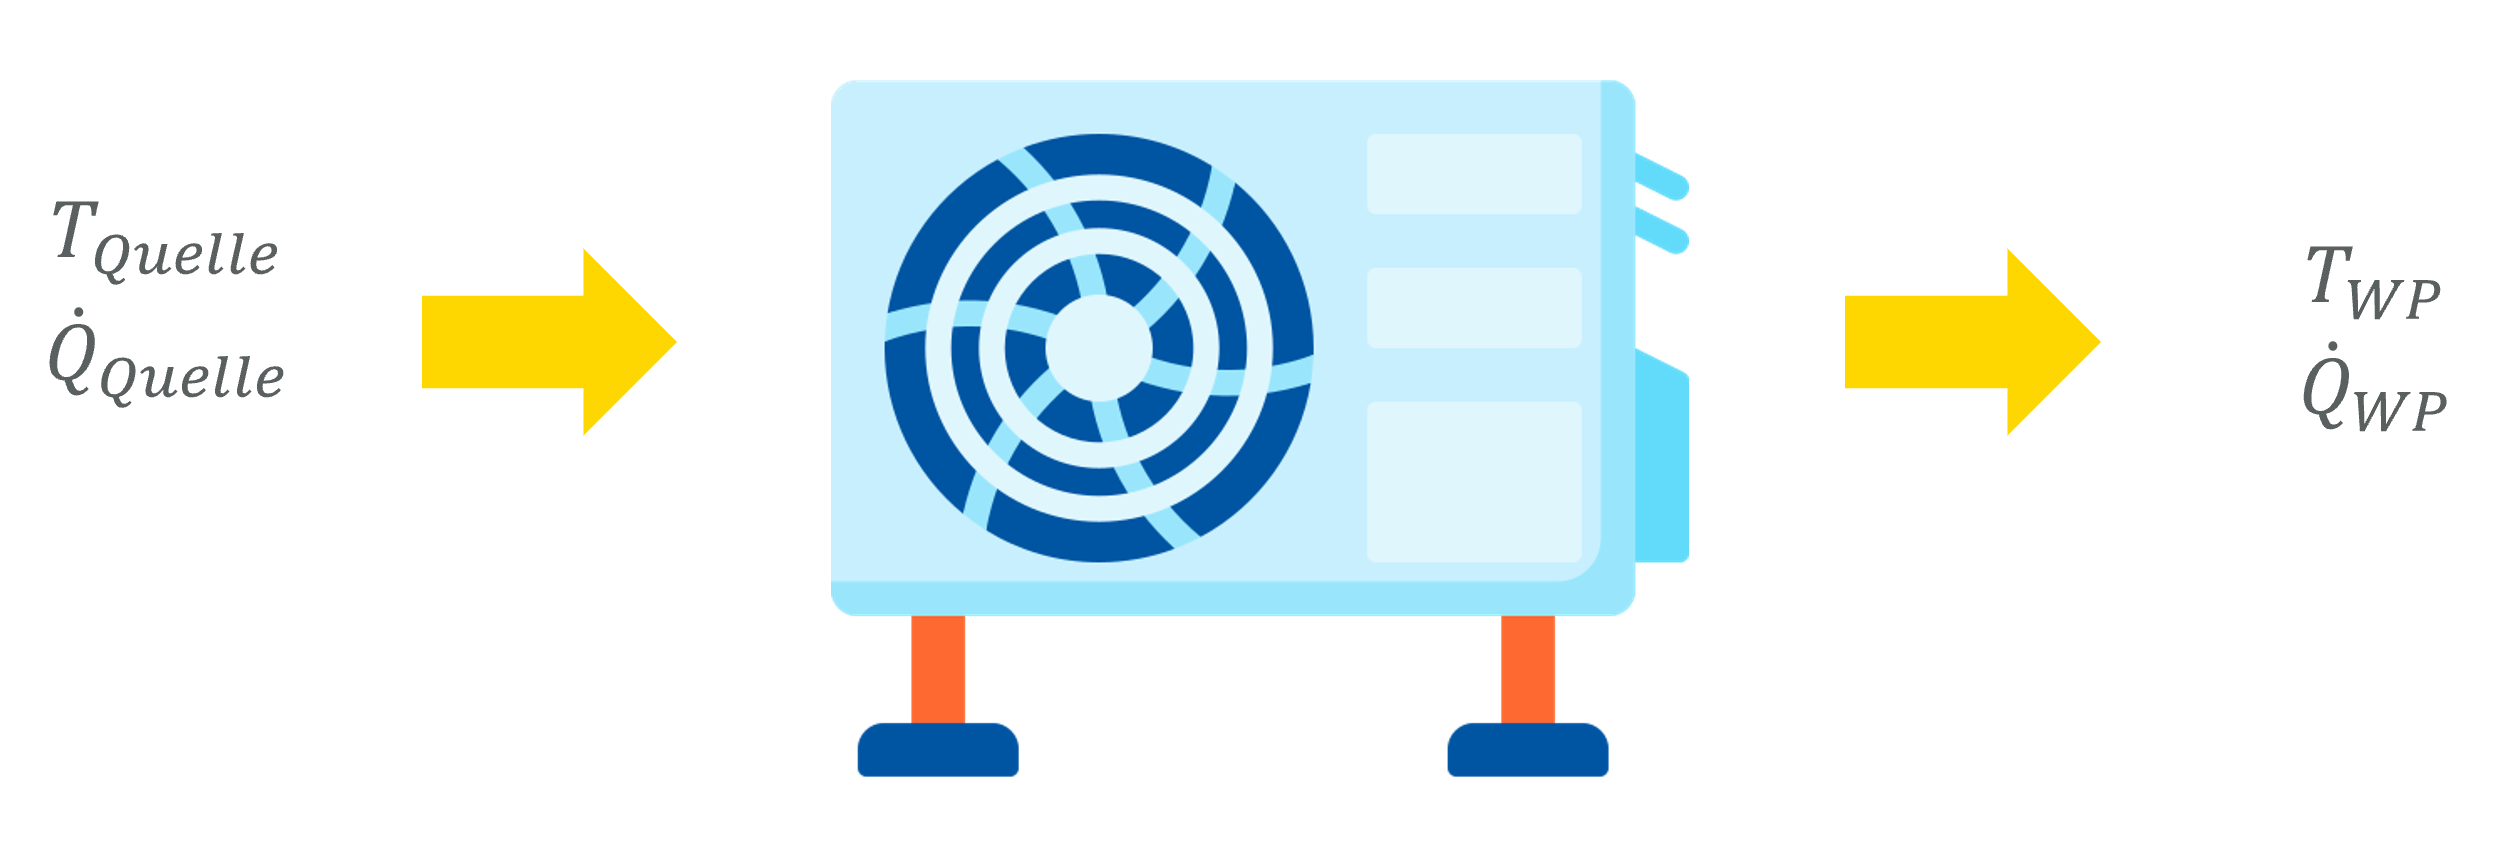

In [168]:
from IPython.display import Image
Image("D:\MASTERARBEIT\Simulation\Bilder\WP.png", width=500, height=300)

#### Technisch

In [169]:
# Die Wärmepumpe wird dazugeschaltet, wenn das Temperaturniveau auf Abnehmerseite nicht eingehalten werden kann. Es soll zunächst nur ein
# einfaches Modell betrachtet werden -> konstanter COP, maximaler Temperaturhub, lineare Kosten pro Leistung

#Eingang
model.WP_T_Verdampfer = Var(domain=NonNegativeReals)
model.WP_Q_Verdampfer = Var(domain=NonNegativeReals) #[kW_th]

#Komponente
model.WP_COP = 4.25 #Entnommen aus Kalkulation Cuxhaven
model.WP_COP_carnot = 0.5 * model.WP_COP
model.WP_P_elektrisch = Var(domain=NonNegativeReals) #[kW_el]

#Ausgang
model.WP_Q_Kondensator = Var(domain=NonNegativeReals)
model.WP_T_Kondensator = Var(domain=NonNegativeReals)
model.WP_T_Kondensator_max = 90+273.15 #[K] #Maximale Kondensatortemperatur
model

#Constraints
model.C_WP_Eingang_T = Constraint( expr = model.WP_T_Verdampfer == model.T_Quelle)
model.C_WP_Eingang_Q = Constraint( expr = model.WP_Q_Verdampfer == model.Q_Quelle_mit) # Wärmeübertragung ohne Verluste
model.C_WP_balance = Constraint( expr = model.WP_Q_Kondensator == model.WP_COP * model.WP_P_elektrisch)
model.C_WP_T_balance = Constraint( expr = model.WP_T_Kondensator == model.WP_T_Verdampfer + model.WP_Q_Kondensator/model.WP_COP_carnot)
model.C_WP_T_Kondensator_max = Constraint(expr = model.WP_T_Kondensator <= model.WP_T_Kondensator_max)

#### Ökonomisch

In [170]:
# Investitionskosten
model.WP_capex = Var(domain=NonNegativeReals)
model.WP_invest = 1654.7 #[€/kW] # Spezifische Investitionskosten pro kW nach Baumgartner et. al.

# Laufkosten
model.WP_opex = Var(domain=NonNegativeReals)
model.c_electricity = 30 #[ct/kWh]

# Constraints
model.C_WP_capex = Constraint( expr = model.WP_capex == model.WP_P_elektrisch * model.WP_invest) # Variabel von der Lesitung
model.C_WP_opex = Constraint( expr = model.WP_opex == model.WP_P_elektrisch * 8760 * model.c_electricity * 0.01)

### Leitung

#### Technisch

In [171]:
"""Die Leitung hat zwar einen Vor- und Rücklauf, aber die Kosten werden über die Trassenlänge definiert. Hier werden Werte für die Verluste und Kosten
Frank Görner verwendet.
Für "die grüne Wiese", also unbebaute Fläche, kann ein Preis von 550 €/m angenommen werden.
Der Verlust über die gesamte Länge ist definiert über die Wärmeleitung in den Erdboden mit ca. 𝜆 = 0,0897 W/mK """

#Eingang
model.L_T_Ein = Var(domain=NonNegativeReals) #[K]
model.L_H_Ein = Var(domain=NonNegativeReals) #[W]

#Komponente
model.lambda_D = 0.0221 #[W/mK] # Leitung durchs Rohr
model.lambda_Bo = 1.6 #[W/mK] # Leitung in den Boden
model.r_M = 0.110 #[m] # Mantel
model.r_R = 0.0418 #[m] # Rohr
model.h_ü = 1 #[m] # Überdeckung
model.L_U = 2*math.pi / (1/model.lambda_D * math.log(model.r_M / model.r_R) + 1 / model.lambda_Bo * math.log(4 * (model.h_ü + model.r_M) / 2 * model.r_M))

model.L_Q_Verlust = Var(domain=NonNegativeReals) # Verlustleistung über Rohrlänge
model.L_l = Var(domain=NonNegativeReals) # Länge des Rohres bzw. Länge der Trasse
model.L_l_max = 10 #[km] # Annahme der maximalen Leitungslänge
model.L_T = Var(domain=NonNegativeReals) # Temperatur an einer bestimmten Stelle im Rohr
model.T_Boden = 10 + 273.15 #[K] # Mittlere Erdreichtemperatur


#Ausgang
model.L_T_Aus = Var(domain=NonNegativeReals) #[K] # Ausgangstemperatur aus der Leitung
model.L_H_Aus = Var(domain=NonNegativeReals) #[kW] # Ausgangswärme aus der Leitung

#Constraints
model.C_L_heat_balance = Constraint( expr = model.L_H_Aus == model.L_H_Ein - model.L_Q_Verlust*0.001) 
""" Vielleicht braucht es die gar nicht,
da schon in der Gleichtung T(l) mit berücksichtigt"""
model.C_L_T = Constraint( expr = model.L_T_Ein == 0.5*(model.WP_T_Kondensator + model.T_Quelle))
""" mit piecewise-linear lösen"""
model.C_L_Q_Verlust = Constraint( expr = model.L_Q_Verlust == model.L_U * model.L_l * (0.5 * (model.L_T_Ein + model.L_T_Aus) - model.T_Boden))
#model.C_L_Q_Verlust = Constraint( expr = model.L_Q_Verlust == model.L_U * model.L_l * (model.L_T - model.T_Boden)
#model.C_L_T = Constraint( expr = model.L_T == model.L_T_Ein - model.L_l / model.L_U *(model.L_H_Ein - model.L_H_aus))
# Laufvariable fehlt, und die Bedingung, dass T_aus = T(x=l) ist
model.C_L_H_Ein = Constraint ( expr = model.L_H_Ein == model.WP_Q_Kondensator + model.Q_Quelle_ohne)
model.C_L_l = Constraint( expr = model.L_l <= model.L_l_max)


#### Ökonomisch

In [172]:
# Investition
model.k_Leitung = 630  #[€/m] # Haupttrasse DN200 mit d=630mm
model.L_capex = Var(domain=NonNegativeReals)

# Constraints
model.C_L_capex = Constraint( expr = model.L_capex == model.k_Leitung * model.L_l)

### Abnehmer

Um eine Plausibilität in der Kalkulation zu erzeugen, ist der Wärmebedarf eine freie Variable. Um diese besser greifen zu können,
wird die Anzahl der Hausanschlüsse verwendet. Ein Einfamilienhaus hat zunächst einen übers Jahr homogenen Wärmebedarf von 20,000 kWh/a.
In einer späteren Version werden saisonale Phänomene mitberücksichtigt.
Die Kosten pro Killowattstunde, die ein Kunde zahlen muss um die Kosten zu decken, ist letztlich die Größe von Interesse.

#### Technisch

In [173]:
#Eingang
model.S_Q_Ein = Var(domain=NonNegativeReals)
model.S_T_Ein = Var(domain=NonNegativeReals)
model.S_T_Soll = 60 + 273.15 #[K] # Diese Temperatur bedingt die notwendige zu erreichende Temperatur des Problems

#Komponente
model.S_n = Var(domain=NonNegativeIntegers) # Anzahl der Hausanschlüsse
model.S_Q_Haus = 20000 #[kWh/a] # Der Wärmebedarf eines Einfamilienhauses für ein Jahr
model.S_Q_min = 500E3 #[kWh] # Mindestbedarf an Wärme für ein Netz

#Constraint
model.C_S_Q_Ein = Constraint( expr = model.S_Q_Ein == model.L_H_Aus)
model.C_S_T_balance = Constraint( expr = model.S_T_Ein == model.L_T_Aus)
model.C_S_T = Constraint( expr = model.S_T_Ein >= model.S_T_Soll)
model.C_S_n = Constraint( expr = model.S_n*model.S_Q_Haus / 8760 >= model.S_Q_Ein)
model.C_S_Q = Constraint( expr = model.S_Q_Ein >= model.S_Q_min / 8760)

#### Ökonomisch

In [174]:
# Investitionskosten
model.A_k = 5000 #[€] # Kosten pro Hausanschluss; überschlagen
model.A_capex = Var(domain=NonNegativeReals)

# Einnahmen
model.A_wärmemischpreis = Var(domain=NonNegativeReals) #[ct/kWh] # Kundenpreis, Einnahme des Unternehmens
model.A_profit = Var(domain=NonNegativeReals) #[€] Einnahmen

# Constraints
model.C_A_capex = Constraint( expr = model.A_capex == model.A_k * model.S_n)
model.C_A_opex = Constraint( expr = model.A_profit == model.A_wärmemischpreis * 0.01 * model.S_n * model.S_Q_Haus)
model.C_A_W = Constraint( expr = model.A_wärmemischpreis <= 23.75) # Wärmemischpreis Luft-Wasser-Wärmepumpe

## Objective Function

In [175]:
# Objective Function enthält nur den Wärmemischpreis, der zu minimieren ist.
model.Preis = Objective(
    expr = model.K_Quelle +  model.WP_capex + model.WP_opex + model.L_capex + model.A_capex - model.A_profit, 
    sense = minimize)

SolverFactory('gurobi').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1
  Lower bound: 176250.0
  Upper bound: 176250.0
  Number of objectives: 1
  Number of constraints: 22
  Number of variables: 24
  Number of binary variables: 0
  Number of integer variables: 1
  Number of continuous variables: 23
  Number of nonzeros: 38
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (

In [179]:
print(f"Kosten = {model.Preis()}")
print(f"Anzahl Häuser = {model.S_n()}")
print(f"Temperatur Quelle = {model.T_Quelle()}")
print(f"Temperatur WP = {model.WP_T_Kondensator()}")
print(f"Temperatur Leitunglänge = {model.L_l()}")

Kosten = 176250.0
Anzahl Häuser = 25.0
Temperatur Quelle = 181.8500971571213
Temperatur WP = 181.85009715712212
Temperatur Leitunglänge = 0.0
